# Recommendations with IBM

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [2]:
user_interactions_file = 'data/user-item-interactions.csv'
articles_file = 'data/articles_community.csv'
matrix_file = 'user_item_matrix.p'

In [3]:
df = pd.read_csv(user_interactions_file)
df_content = pd.read_csv(articles_file)
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
df.shape[0]

45993

In [6]:
df_content.shape[0]

1056

In [7]:
df['email'].nunique()

5148

In [8]:
df_content['article_id'].nunique()

1051

In [9]:
users_df = df.groupby(['email']).count()
users_df.drop(['title'], axis=1, inplace=True)
users_df.rename(columns={"article_id": "article_count"}, inplace=True)
users_df.sort_values( by='article_count',  ascending=False, inplace=True)
users_df.describe()

,article_count
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


Text(0.5, 1.0, 'Number of interactions for users')

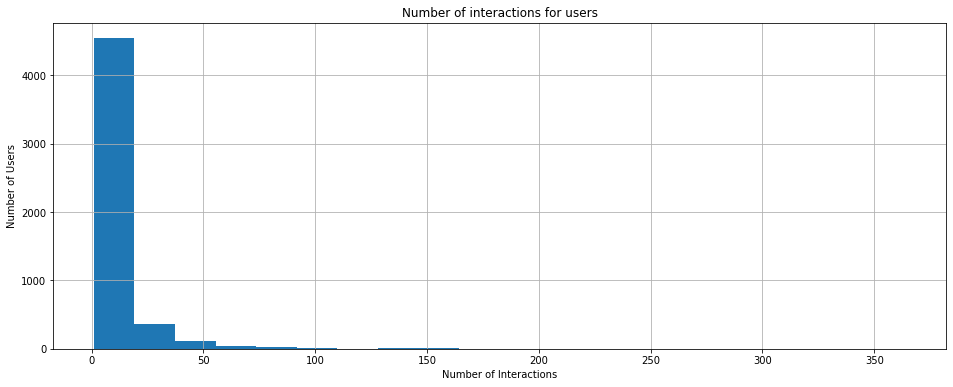

In [10]:
# plot number of interactions for users
users_df['article_count'].hist(bins=20, figsize=(16,6))
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.title('Number of interactions for users')

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [11]:
# Find and explore duplicate articles
df_content[df_content.duplicated(['article_id'])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [12]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], inplace=True)

In [13]:
df_content.shape[0]

1051

In [14]:
df.groupby(['article_id']).count().sort_values(by=['title'], ascending=False).head()

,title,email
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671
1427.0,643,643
1364.0,627,627


In [15]:
articles_df = df.groupby(['article_id']).count()
articles_df.drop(['title'], axis=1, inplace=True)
articles_df.rename(columns={"email": "email_count"}, inplace=True)
articles_df.sort_values( by='email_count',  ascending=False, inplace=True)
articles_df.describe()

,email_count
count,714.000000
mean,64.392157
std,109.161462
min,1.000000
25%,8.000000
50%,25.000000
75%,69.000000
max,937.000000


Text(0.5, 1.0, 'Number of interactions for articles')

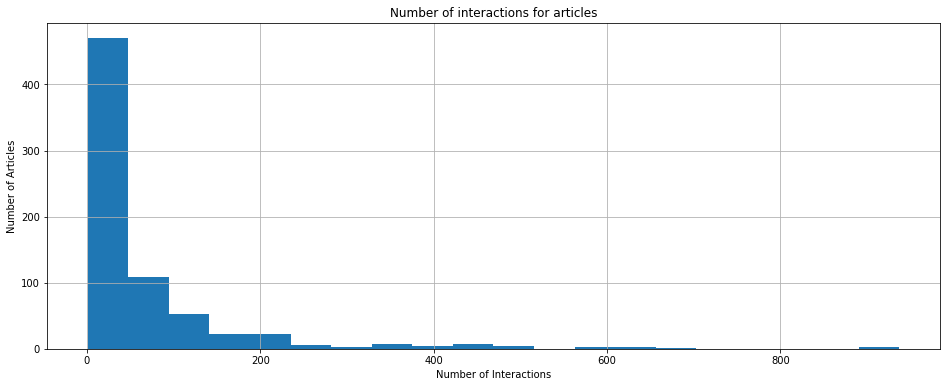

In [16]:
# plot number of interactions for articles
articles_df['email_count'].hist(bins=20, figsize=(16,6))
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Articles')
plt.title('Number of interactions for articles')

In [17]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [18]:
#Function to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

In [19]:
email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In [20]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = []
    top_article_ids = get_top_article_ids(n, df)
    for id in top_article_ids:
        top_articles.append(df.query('article_id == ' + id).iloc[0]['title'])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby(['article_id']).count().sort_values(by=['title'], ascending=False).index)[:n]
    
    # return string format
    top_articles = [str(i) for i in top_articles]
    
    return top_articles # Return the top article ids

In [21]:
print('Top 10 articles')
top_articles_dict = {'id':get_top_article_ids(10), 'name':get_top_articles(10)}
pd.DataFrame(top_articles_dict)

Top 10 articles


,id,name
0,1429.0,use deep learning for image classification
1,1330.0,insights from new york car accident reports
2,1431.0,visualize car data with brunel
3,1427.0,"use xgboost, scikit-learn & ibm watson machine..."
4,1364.0,predicting churn with the spss random tree alg...
5,1314.0,healthcare python streaming application demo
6,1293.0,finding optimal locations of new store using d...
7,1170.0,"apache spark lab, part 1: basic concepts"
8,1162.0,analyze energy consumption in buildings
9,1304.0,gosales transactions for logistic regression m...


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Function below reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** only appear in each **row** once.


* Each **article** only show up in one **column**.  


* **If a user has interacted with an article, then 1 is placed where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article are a 1.  


* **If a user has not interacted with an item, then a zero is placed where the user-row meets for that article-column**. 

In [22]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(by=['user_id', 'article_id'])['title'].any().unstack().fillna(False)

    # converting True/False to 1/0
    user_item = user_item * 1
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

`2.` The function below takes a user_id and provides an ordered list of the most similar users to that user (from most similar to least similar).  The returned result does not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.

In [23]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity_dict = dict()
    for user_id_ in list(user_item.index):
        similarity_dict[user_id_] = np.dot(user_item.loc[user_id], user_item.loc[user_id_])

    # sort by similarity
    sorted_similarity_dict = sorted(similarity_dict.items(), key=lambda x: x[1], reverse=True)
    
    # create list of just the ids
    most_similar_users = [a[0] for a in sorted_similarity_dict]
    
    # remove the own user's id
    idx = most_similar_users.index(user_id)
    most_similar_users.pop(idx)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [24]:
# Do a spot check
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that we have a function that provides the most similar users to each user, we will use these users to find articles we can recommend.

In [25]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = []
    for id in article_ids:
        article_names.append(df.query('article_id == ' + str(id)).iloc[0]['title'])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = []
    article_names = []
    
    if user_id in user_item.index:
        article_ids = list(dict(user_item.loc[user_id][user_item.loc[user_id] > 0]))
        article_ids = [str(a) for a in article_ids]
        article_names = get_article_names(article_ids)
        
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs= np.array([])
    user_articles = get_user_articles(user_id)
    similar_users = find_similar_users(user_id)
    for similar_user in similar_users:
        similar_user_article_ids, similar_user_article_names = get_user_articles(similar_user)
        new_recs = np.setdiff1d(similar_user_article_ids, user_articles, assume_unique=True)
        recs = np.unique(np.concatenate([recs, new_recs], axis=0))
        if len(recs) >= m:
            break
    recs = recs[:m]
    return recs # return recommendations for this user_id    

In [26]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function above.

In [27]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of each user to the provided user
    similarity_dict = dict()
    for user_id_ in list(user_item.index):
        if(user_id in user_item.index):
            similarity_dict[user_id_] = np.dot(user_item.loc[user_id], user_item.loc[user_id_])
    
    neighbors_df = pd.DataFrame.from_dict(similarity_dict, orient='index', columns=['similarity'])
    # reset index to make index a column
    neighbors_df = neighbors_df.reset_index()
    neighbors_df = neighbors_df.rename(columns={"index": "neighbor_id"})
    
    # remove user id from df
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    # add column for 
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(lambda x: len(user_item.loc[x][user_item.loc[x] > 0]))
    
    # sort the df
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    neighbors_df = get_top_sorted_users(user_id)
    articles_df = df.groupby(['article_id']).count().sort_values(by=['title'], ascending=False)
    articles_df = articles_df.drop(columns='user_id')
    articles_df = articles_df.rename(columns={"title": "count"})
    
    recs= np.array([])
    user_articles = get_user_articles(user_id)
    for similar_user in neighbors_df['neighbor_id']:
        similar_user_article_ids, similar_user_article_names = get_user_articles(similar_user)        
        new_recs = np.setdiff1d(similar_user_article_ids, user_articles, assume_unique=True)
        
        # sort the new recs by count
        counts = []
        for nr in new_recs:
            counts.append(articles_df.loc[float(nr)]['count'])
        
        counts = np.array(counts)
        inds = counts.argsort()
        new_recs = new_recs[inds]
        
        recs = np.unique(np.concatenate([recs, new_recs], axis=0))
        print(len(recs))
        if len(recs) >= m:
            break
    
    recs = recs[:m]
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [28]:
# Quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

70
The top 10 recommendations for user 20 are the following article ids:
['1014.0' '1059.0' '109.0' '111.0' '1157.0' '1162.0' '1164.0' '1172.0'
 '1186.0' '12.0']

The top 10 recommendations for user 20 are the following article names:
['1448    i ranked every intro to data science course on...\nName: title, dtype: object', 'airbnb data for analytics: amsterdam calendar', 'tensorflow quick tips', 'tidy up your jupyter notebooks with scripts', 'airbnb data for analytics: washington d.c. listings', 'analyze energy consumption in buildings', 'analyze open data sets with pandas dataframes', 'apache spark lab, part 3: machine learning', 'connect to db2 warehouse on cloud and db2 using scala', 'timeseries data analysis of iot events by using jupyter notebook']


In [29]:
recs_dict = {'rec_id':rec_ids, 'rec_name':rec_names}
print('Top 10 recommendations for user 20')
pd.DataFrame(recs_dict)

Top 10 recommendations for user 20


,rec_id,rec_name
0,1014.0,1448 i ranked every intro to data science c...
1,1059.0,airbnb data for analytics: amsterdam calendar
2,109.0,tensorflow quick tips
3,111.0,tidy up your jupyter notebooks with scripts
4,1157.0,airbnb data for analytics: washington d.c. lis...
5,1162.0,analyze energy consumption in buildings
6,1164.0,analyze open data sets with pandas dataframes
7,1172.0,"apache spark lab, part 3: machine learning"
8,1186.0,connect to db2 warehouse on cloud and db2 usin...
9,12.0,timeseries data analysis of iot events by usin...


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, we will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [30]:
# Load the matrix here
user_item_matrix = pd.read_pickle(matrix_file)

In [31]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, we can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [32]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True)

In [33]:
print(u.shape)
print(s.shape)
print(vt.shape)

(5149, 5149)
(714,)
(714, 714)


In the lesson we performed SVD on a subset of data as the complete dataset has many missing values.
Here, we can perform SVD on complete data as ther are no missing values

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [34]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [ ]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [ ]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train).astype('float64')
    user_item_test = create_user_item_matrix(df_test).astype('float64')
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    # convert to string - as articles are string
    test_arts = [str(i) for i in test_arts]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [ ]:
# common users in test and train
len(set(user_item_train.index).intersection(set(user_item_test.index)))

In [ ]:
# different users in test not in train
len(set(user_item_test.index).difference(set(user_item_train.index)))

In [ ]:
# common movies in test and train
len(set(user_item_train.columns).intersection(set(user_item_test.columns)))

In [ ]:
# different movies in test not in train
len(set(user_item_test.columns).difference(set(user_item_train.columns)))

In [ ]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [ ]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train =  np.linalg.svd(user_item_train, full_matrices=True) # fit svd similar to above then use the cells below

In [ ]:
print(u_train.shape)
print(s_train.shape)
print(vt_train.shape)

In [ ]:
def make_prediction(user_id, article_id, user_item_train=user_item_train, user_matrix= u_train, article_matrix=vt_train.T, num_features=714):
    user_ids = np.array(user_item_train.index)
    artcle_ids = np.array(user_item_train.columns)
    
    user_row = np.where(user_ids == user_id)[0][0]
    article_col = np.where(artcle_ids == article_id)[0][0]
    
    # take dot product
    pred = np.dot(user_matrix[user_row, :num_features], article_matrix[:num_features,article_col])
    
    return pred

In [ ]:
# make predictions for all users that can be predicted on
diff_squared_sum = 0
for user in list(set(user_item_train.index).intersection(set(user_item_test.index))):
    for article in user_item_test.columns:
        pred = make_prediction(user, article, num_features = 100)
        actual = user_item_test.loc[user, article]
        diff_squared_sum += (actual - pred)**2
        
print(diff_squared_sum)

In [ ]:
num_latent_feats = np.arange(10,570,20)
sum_errs_train = []
sum_errs_test = []

user_ids = np.array(user_item_train.index)
common_ids = list(set(user_item_train.index).intersection(set(user_item_test.index)))

article_ids = np.array(user_item_train.columns)
common_articles = list(set(user_item_train.columns).intersection(set(user_item_test.columns)))

user_test_rows = np.where(np.in1d(user_ids, np.array(common_ids)))[0]
user_test_columns = np.where(np.in1d(article_ids, np.array(common_articles)))[0]

u_test = u_train[user_test_rows,:]
u_test = u_test[:,user_test_columns]

vt_test = vt_train[:,user_test_columns]
user_item_test_new = user_item_test.loc[common_ids, common_articles]

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new_train, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    u_new_test = u_test[:, :k]
    vt_new_test = vt_test[:k, :]
    
    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_new_train, s_new), vt_new))
    user_item_test_est = np.around(np.dot(np.dot(u_new_test, s_new), vt_new_test))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test_new, user_item_test_est)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)
    
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0] * user_item_train.shape[1]));
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test_new.shape[0] * user_item_test_new.shape[1]));

plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend(['train','test'])

As we increase the number of latent features, training accuracy increases and testing accuracy decreases.

We can run an A/B test to determine if number of user interactions increases after we implement new method of recommendations.

We will observe the difference for number of interactions with recommended articles in control and expertiment groups. The control group will continue to get recommendations based on 